In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from datetime import date, timedelta
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import LSTM
from keras import callbacks
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import gc

Using TensorFlow backend.


In [3]:
import pandas as pd

## Load this is raw data

In [4]:
df_chunk = pd.read_csv('train.csv',chunksize=1000000,parse_dates = ['date'],
                       converters={'unit_sales': lambda u: np.log1p(float(u)) if float(u) > 0 else 0})

chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in df_chunk:  
    chunk_list.append(chunk)
    
# concat the list into dataframe 
dataset = pd.concat(chunk_list)

## Load this for combined data + oil + category

In [9]:
df_chunk = pd.read_csv('combined.csv',chunksize=1000000,parse_dates = ['date'],converters={'unit_sales': lambda u: np.log1p(float(u)) if float(u) > 0 else 0})

chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in df_chunk:  
    chunk_list.append(chunk)
    
# concat the list into dataframe 
dataset = pd.concat(chunk_list)

## Function by terrence

In [5]:
# Lookback time feature
def add_time_diff(df, ori_col, shift_count):
    shift = df[ori_col].shift(shift_count)
    new_col = ori_col + str(shift_count)
    df[new_col] = shift
    return df

def preprocess_data(train_dataset):
    print('Loading dataset')
    # remove nrows count when saving data
    #train_dataset = pd.read_csv('data/train.csv', nrows=10000)
    holidays_dataset = pd.read_csv('data/holidays_events.csv')
    item_dataset = pd.read_csv('data/items.csv')
    store_dataset = pd.read_csv('data/stores.csv')
    oil_dataset = pd.read_csv('data/oil.csv')

    min_date = min(train_dataset['date'])
    max_date = max(train_dataset['date'])
    # Create new DataFrame to take into account missing data
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    date_range[:10]

    train_df = pd.DataFrame(date_range, columns=['date'])
    train_df['unit_sales'] = 0

    train_dataset['date'] = pd.to_datetime(train_dataset['date'])
    train_df = train_df.merge(train_dataset, how='left', on='date').drop(['unit_sales_x'], axis=1).fillna(0)
    train_df.rename(columns={'unit_sales_y': 'unit_sales'}, inplace=True)

    for day in range(1,8):
        train_df = add_time_diff(train_df, 'unit_sales', day)
        
    train_df['onpromotion_cat'] = train_df['onpromotion'].apply(lambda x: 0 if x==False else 1)
    train_df = train_df.drop(['onpromotion'],axis =1)
    
    # Get date features
    train_df['year'] = train_df['date'].dt.year
    train_df['day_of_year'] = train_df['date'].dt.dayofyear
    train_df['day_of_week'] = train_df['date'].dt.weekday
    train_df['week_of_year'] = train_df['date'].dt.week
    train_df['month'] = train_df['date'].dt.month
    train_df['quarter'] = train_df['date'].dt.quarter
    train_df["weekday"] = (train_df["day_of_week"] < 5).astype(int)
    '''
    # Get holiday features
    holidays_dataset['date'] = pd.to_datetime(holidays_dataset['date'])
    holidays_dataset = pd.get_dummies(holidays_dataset, columns=['locale','locale_name', 'type'], prefix=['locale','locale_name', 'holiday_type'])
    holidays_dataset = holidays_dataset.drop(columns=['description','transferred'])
    train_df = train_df.merge(holidays_dataset, how='left', on='date')
    train_df.rename(columns={'type': 'holiday_type'}, inplace=True)
    '''
    # Get item features
    item_dataset = pd.get_dummies(item_dataset, columns=['family'], prefix=['family'])
    item_dataset = item_dataset.drop(columns=['class'])
    train_df = train_df.merge(item_dataset, how='left', on='item_nbr')
    '''
    # Get store features
    store_dataset['city_state'] = store_dataset[['city', 'state']].apply(lambda x: '_'.join(x), axis=1)
    store_dataset = pd.get_dummies(store_dataset, columns=['city_state', 'type'], prefix=['city_state', 'store_type'])
    store_dataset = store_dataset.drop(columns=['city', 'state'])
    train_df = train_df.merge(store_dataset, how='left', on='store_nbr')
    train_df.rename(columns={'type': 'location_type'}, inplace=True)
    '''
    # Get oil features
    oil_dataset['date'] = pd.to_datetime(oil_dataset['date'])
    oil_dataset = oil_dataset.sort_values(by=['date'], ascending=[True])
    oil_dataset.set_index('date', inplace=True)
    oil_dataset = oil_dataset.resample('D').ffill().reset_index()
    train_df = train_df.merge(oil_dataset, how='left', on='date')
    
    train_df['dcoilwtico'] = train_df['dcoilwtico'].fillna(method='ffill')
    train_df = train_df.fillna(0)
    # Encoding for tree-based methods
    # DONE
    
    print('@create_dataset - done with preprocess')
    return train_df

#dataset = preprocess_data()
#print(dataset.head())
#print(dataset.columns)

## split data by year and perform joining because data is too big

In [3]:
oil_dataset = pd.read_csv('data/oil.csv')
oil_dataset['date'] = pd.to_datetime(oil_dataset['date'])
oil_dataset = oil_dataset.sort_values(by=['date'], ascending=[True])
oil_dataset.set_index('date', inplace=True)
oil_dataset = oil_dataset.resample('D').ffill().reset_index()
item_dataset = pd.read_csv('data/items.csv')

In [4]:
dataset_2017 = dataset[dataset['date'].dt.year == 2017]
dataset_2016 = dataset[dataset['date'].dt.year == 2016]
dataset_2015 = dataset[dataset['date'].dt.year == 2015]

In [5]:
dataset_2017_items = dataset_2017.merge(item_dataset,how='left',on = 'item_nbr')
dataset_2016_items = dataset_2016.merge(item_dataset,how='left',on = 'item_nbr')
dataset_2015_items = dataset_2015.merge(item_dataset,how='left',on = 'item_nbr')

In [6]:
dataset_2017_items = dataset_2017_items.merge(oil_dataset, how='left', on='date')
dataset_2016_items = dataset_2016_items.merge(oil_dataset, how='left', on='date')
dataset_2015_items = dataset_2015_items.merge(oil_dataset, how='left', on='date')

In [7]:
dataset_2017_items['day_of_year'] = dataset_2017_items['date'].dt.dayofyear
dataset_2017_items['day_of_week'] = dataset_2017_items['date'].dt.weekday
dataset_2017_items['week_of_year'] = dataset_2017_items['date'].dt.week

dataset_2016_items['day_of_year'] = dataset_2016_items['date'].dt.dayofyear
dataset_2016_items['day_of_week'] = dataset_2016_items['date'].dt.weekday
dataset_2016_items['week_of_year'] = dataset_2016_items['date'].dt.week

dataset_2015_items['day_of_year'] = dataset_2015_items['date'].dt.dayofyear
dataset_2015_items['day_of_week'] = dataset_2015_items['date'].dt.weekday
dataset_2015_items['week_of_year'] = dataset_2015_items['date'].dt.week

In [8]:
dataset_2017_items['onpromotion_cat'] = dataset_2017_items['onpromotion'].apply(lambda x: 0 if x==False else 1)
dataset_2017_items = dataset_2017_items.drop(['onpromotion'],axis =1)

dataset_2016_items['onpromotion_cat'] = dataset_2016_items['onpromotion'].apply(lambda x: 0 if x==False else 1)
dataset_2016_items = dataset_2016_items.drop(['onpromotion'],axis =1)

dataset_2015_items['onpromotion_cat'] = dataset_2015_items['onpromotion'].apply(lambda x: 0 if x==False else 1)
dataset_2015_items = dataset_2015_items.drop(['onpromotion'],axis =1)

### combined and output

In [ ]:
dataset_2015_items.to_csv('dataset_2015_items.csv',index = False)

In [9]:
combined = dataset_2017_items.append(dataset_2016_items).append(dataset_2015_items)

In [11]:
combined.to_csv('combined.csv',index = False)

# By Category

In [8]:
category_1['year'] = category_1['date'].dt.year
category_1['dcoilwtico'] = category_1['dcoilwtico'].fillna(method='ffill')
category_1

,id,date,store_nbr,item_nbr,unit_sales,family,class,perishable,dcoilwtico,day_of_year,day_of_week,week_of_year,onpromotion_cat,year
6,101688785,2017-01-01,25,108786,1.0000,CLEANING,3044,0,53.7500,1,6,52,0,2017
9,101688788,2017-01-01,25,108952,2.0000,CLEANING,3024,0,53.7500,1,6,52,0,2017
11,101688790,2017-01-01,25,114800,6.0000,PERSONAL CARE,4126,0,53.7500,1,6,52,0,2017
12,101688791,2017-01-01,25,115267,2.0000,CLEANING,3034,0,53.7500,1,6,52,0,2017
20,101688799,2017-01-01,25,119026,1.0000,CLEANING,3026,0,53.7500,1,6,52,0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86902665,66458797,2015-12-31,54,1913600,1.0000,PERSONAL CARE,4118,0,37.1300,365,3,53,0,2015
86902666,66458798,2015-12-31,54,1913604,1.0000,PERSONAL CARE,4118,0,37.1300,365,3,53,0,2015
86902672,66458804,2015-12-31,54,1915000,1.0000,PERSONAL CARE,4122,0,37.1300,365,3,53,0,2015
86902690,66458822,2015-12-31,54,1938021,1.0000,PERSONAL CARE,4138,0,37.1300,365,3,53,0,2015


Text(0.5, 1.0, 'Sales by Year Across Years')

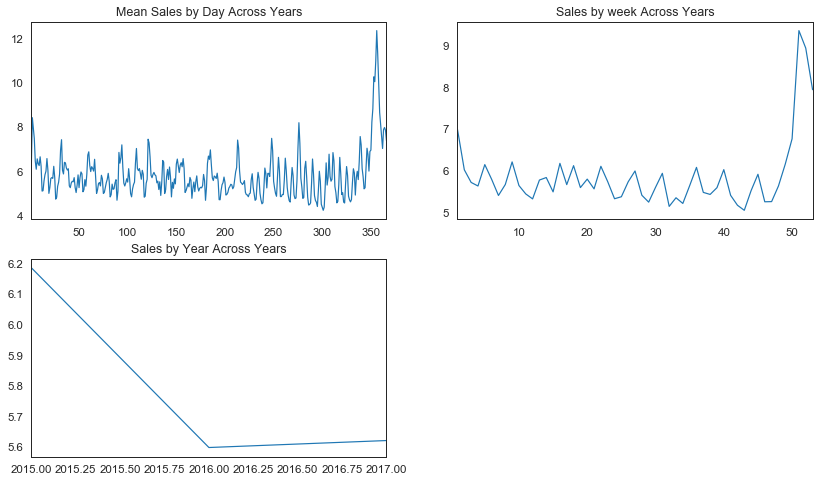

In [35]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
category_1.groupby('day_of_year').unit_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Day Across Years')

plt.subplot(2,2,2)
category_1.groupby('week_of_year').unit_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Sales by week Across Years')

plt.subplot(2,2,3)
category_1.groupby('year').unit_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Sales by Year Across Years')

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [10]:
store_44 = dataset[dataset['store_nbr'] == 44]
store_44 = store_44.sort_values('date')
store_44 = store_44.reset_index()
store_44['month'] = store_44['date'].dt.month
store_44['month'] = store_44['date'].dt.dayofweek
store_44

,index,id,date,store_nbr,item_nbr,unit_sales,family,class,perishable,dcoilwtico,day_of_year,day_of_week,week_of_year,onpromotion_cat,month
0,59084905,38641037,2015-01-02,44,103520,2.3979,GROCERY I,1028,0,52.7200,2,4,1,0,4
1,59086071,38642203,2015-01-02,44,1047735,2.7726,BEVERAGES,1124,0,52.7200,2,4,1,0,4
2,59086070,38642202,2015-01-02,44,1047734,1.3863,BEVERAGES,1124,0,52.7200,2,4,1,0,4
3,59086069,38642201,2015-01-02,44,1047733,3.3322,BEVERAGES,1124,0,52.7200,2,4,1,0,4
4,59086068,38642200,2015-01-02,44,1047721,3.0445,BEVERAGES,1122,0,52.7200,2,4,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364886,23783305,125472084,2017-08-15,44,902839,2.0794,GROCERY I,1060,0,47.5700,227,1,33,0,1
2364887,23783306,125472085,2017-08-15,44,903283,3.0408,POULTRY,2416,1,47.5700,227,1,33,0,1
2364888,23783307,125472086,2017-08-15,44,903284,2.7138,POULTRY,2416,1,47.5700,227,1,33,0,1
2364889,23783299,125472078,2017-08-15,44,890374,0.6931,GROCERY I,1002,0,47.5700,227,1,33,0,1


In [11]:
categories = list(store_44['family'].unique())
len(categories)

32

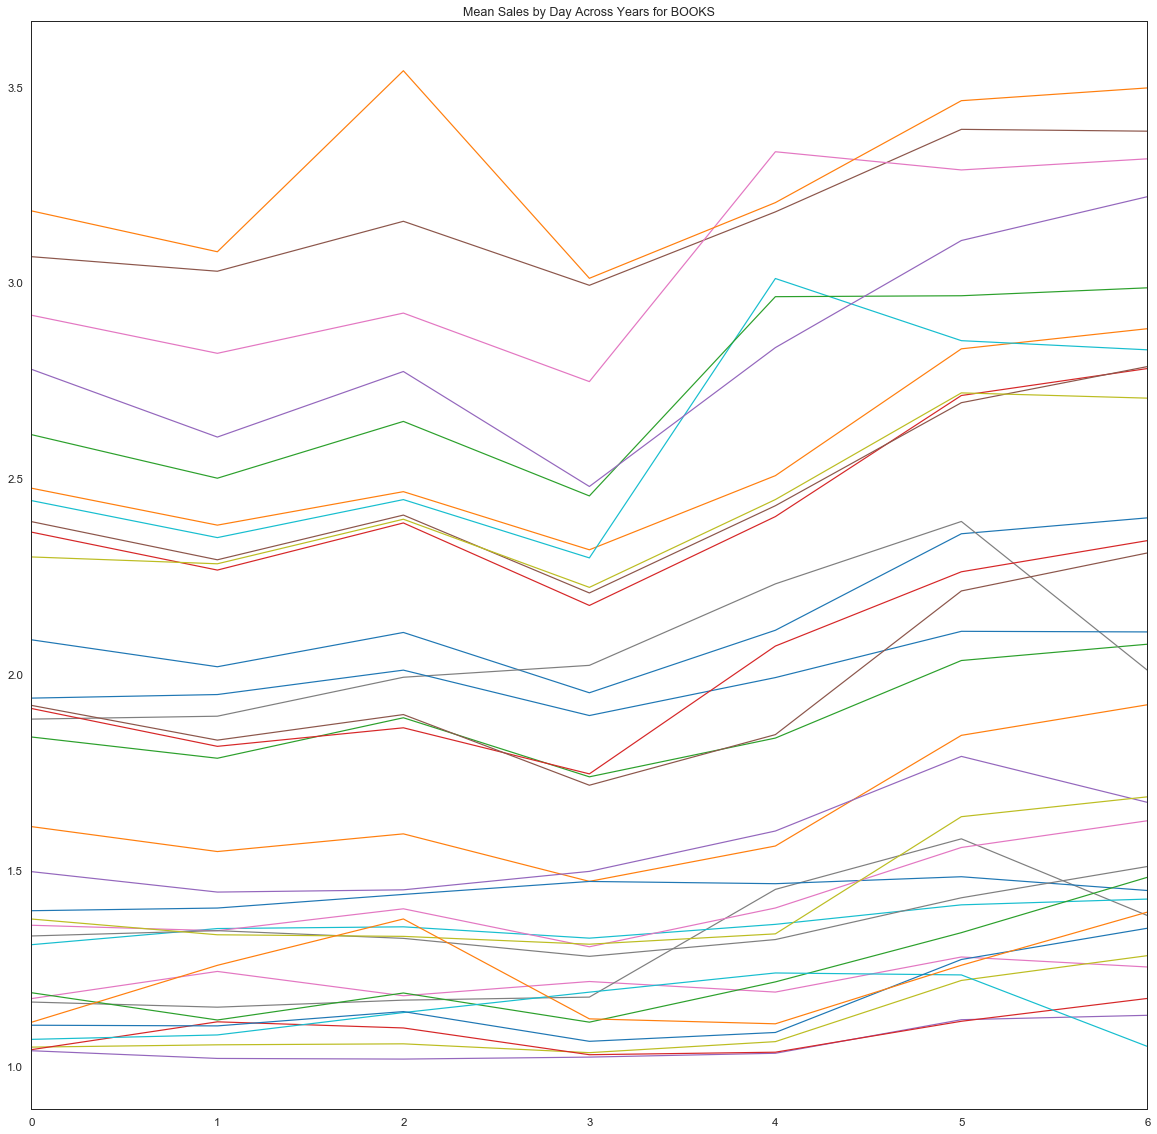

In [12]:
plt.figure(figsize=(20,20))
counter = 1
for category in categories:
    #plt.subplot(16,2,counter)
    counter += 1
    store_44[store_44['family'] == category].groupby('month').unit_sales.agg('mean').plot()
    plt.xlabel('')
    plt.title(f'Mean Sales by Day Across Years for {category}')

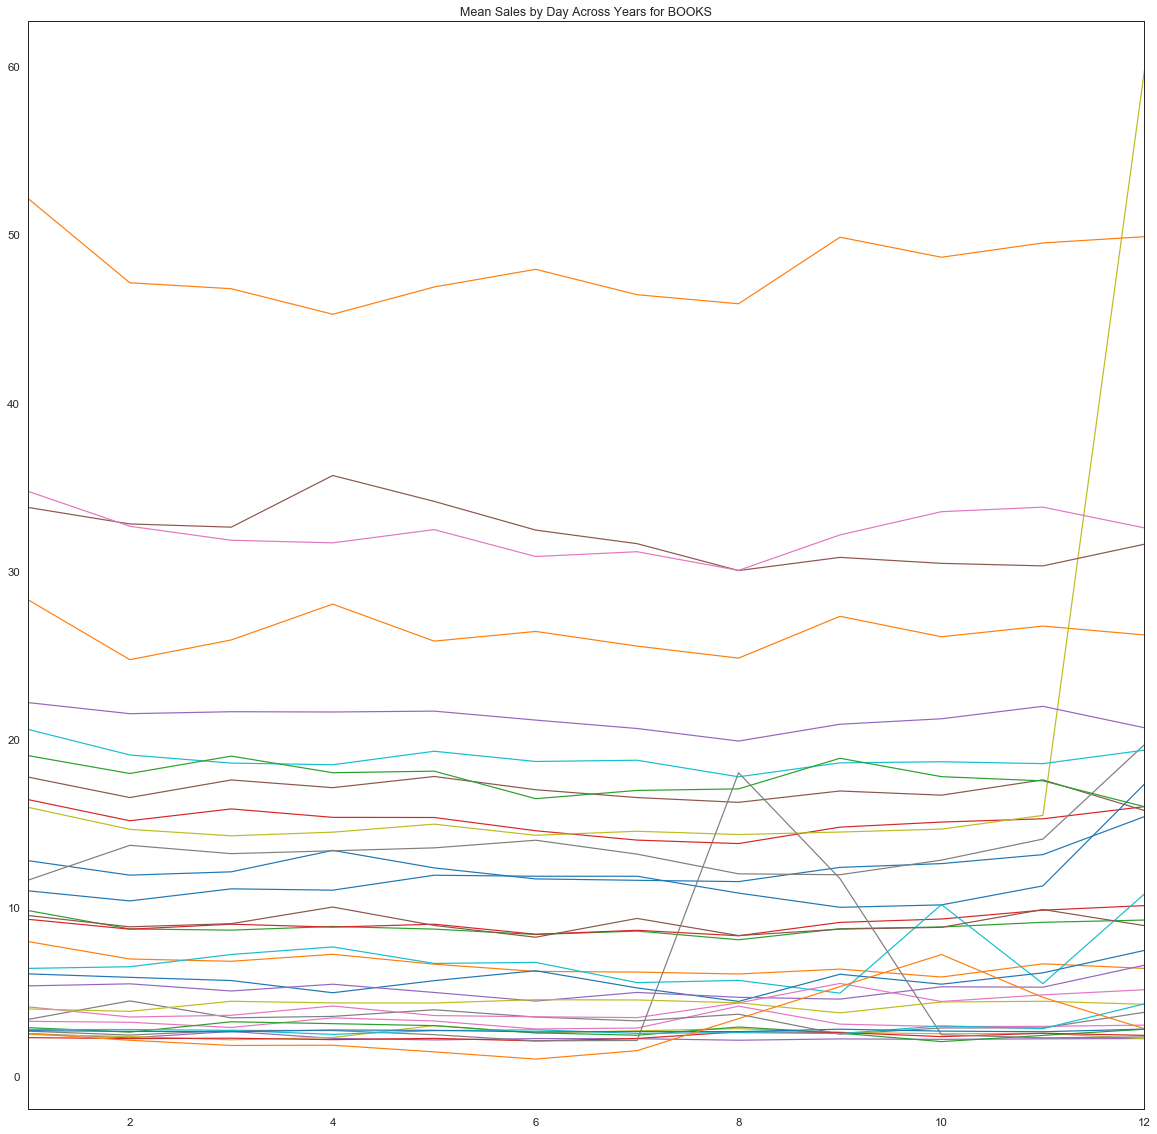

In [36]:
plt.figure(figsize=(20,20))
counter = 1
for category in categories:
    #plt.subplot(16,2,counter)
    counter += 1
    store_44[store_44['family'] == category].groupby('month').unit_sales.agg('mean').plot()
    plt.xlabel('')
    plt.title(f'Mean Sales by Day Across Years for {category}')

In [13]:
for day in range(1,8):
    store_44 = add_time_diff(store_44, 'unit_sales', day)
store_44 = store_44.fillna(0)

In [14]:
store_44 = store_44.join(pd.get_dummies(store_44['family']))

#store_44 = store_44.drop(['family'],axis = 1)
store_44.columns.values

array(['index', 'id', 'date', 'store_nbr', 'item_nbr', 'unit_sales',
       'family', 'class', 'perishable', 'dcoilwtico', 'day_of_year',
       'day_of_week', 'week_of_year', 'onpromotion_cat', 'month',
       'unit_sales1', 'unit_sales2', 'unit_sales3', 'unit_sales4',
       'unit_sales5', 'unit_sales6', 'unit_sales7', 'AUTOMOTIVE',
       'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION',
       'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I',
       'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE',
       'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
       'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
       'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE',
       'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'], dtype=object)

#### 

In [15]:

store_44.head()

,index,id,date,store_nbr,item_nbr,unit_sales,family,class,perishable,dcoilwtico,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
0,59084905,38641037,2015-01-02,44,103520,2.3979,GROCERY I,1028,0,52.7200,...,0,0,0,0,0,0,0,0,0,0
1,59086071,38642203,2015-01-02,44,1047735,2.7726,BEVERAGES,1124,0,52.7200,...,0,0,0,0,0,0,0,0,0,0
2,59086070,38642202,2015-01-02,44,1047734,1.3863,BEVERAGES,1124,0,52.7200,...,0,0,0,0,0,0,0,0,0,0
3,59086069,38642201,2015-01-02,44,1047733,3.3322,BEVERAGES,1124,0,52.7200,...,0,0,0,0,0,0,0,0,0,0
4,59086068,38642200,2015-01-02,44,1047721,3.0445,BEVERAGES,1122,0,52.7200,...,0,0,0,0,0,0,0,0,0,0


# LSTM FULL

In [17]:
#df = store_44[store_44['family'] == 'GROCERY I']
y = store_44['unit_sales'].values
df = store_44.drop(['item_nbr','index','id','date','store_nbr','class','unit_sales','family'],axis = 1)
df

,perishable,dcoilwtico,day_of_year,day_of_week,week_of_year,onpromotion_cat,month,unit_sales1,unit_sales2,unit_sales3,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
0,0,52.7200,2,4,1,0,4,0.0000,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
1,0,52.7200,2,4,1,0,4,2.3979,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
2,0,52.7200,2,4,1,0,4,2.7726,2.3979,0.0000,...,0,0,0,0,0,0,0,0,0,0
3,0,52.7200,2,4,1,0,4,1.3863,2.7726,2.3979,...,0,0,0,0,0,0,0,0,0,0
4,0,52.7200,2,4,1,0,4,3.3322,1.3863,2.7726,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364886,0,47.5700,227,1,33,0,1,2.7726,2.6794,2.4849,...,0,0,0,0,0,0,0,0,0,0
2364887,1,47.5700,227,1,33,0,1,2.0794,2.7726,2.6794,...,0,0,0,0,0,1,0,0,0,0
2364888,1,47.5700,227,1,33,0,1,3.0408,2.0794,2.7726,...,0,0,0,0,0,1,0,0,0,0
2364889,0,47.5700,227,1,33,0,1,2.7138,3.0408,2.0794,...,0,0,0,0,0,0,0,0,0,0


In [22]:
y = np.reshape(y, (-1, 1))

scaler = MinMaxScaler(feature_range=(0, 1))
df[['unit_sales1', 'unit_sales2', 'unit_sales3', 'unit_sales4', 'unit_sales5', 'unit_sales6', 'unit_sales7']] = scaler.fit_transform(df[['unit_sales1', 'unit_sales2', 'unit_sales3', 'unit_sales4', 'unit_sales5', 'unit_sales6', 'unit_sales7']])

dataset = df.values

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)
#y = scaler.fit_transform(y)
X_train, X_test, Y_train, Y_test = train_test_split(dataset, y, test_size=0.3, random_state=1, shuffle = False)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
Y_train = np.asarray(Y_train)
Y_test = np.asarray(Y_test)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Y_train_2 = []
for y in Y_train:
    Y_train_2.append(y[0])
Y_train = np.asarray(Y_train_2)

Y_test_2 = []
for y in Y_test:
    Y_test_2.append(y[0])
Y_test = np.asarray(Y_test_2)
print(X_train.shape,Y_train.shape)

(1655423, 1, 46) (1655423,)


In [26]:
X_train[10]

array([[ 0.        , 52.72      ,  2.        ,  4.        ,  1.        ,
         0.        ,  4.        ,  0.19934029,  0.1790563 ,  0.19934029,
         0.07711535,  0.25617165,  0.3387151 ,  0.37072087,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [27]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=1000, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', mode = 'min', patience=10)], verbose=1, shuffle=False)

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1655423 samples, validate on 709468 samples
Epoch 1/100
1655423/1655423 [==============================] - 45s 27us/step - loss: 0.0196 - val_loss: 0.0158
Epoch 2/100
1655423/1655423 [==============================] - 42s 26us/step - loss: 0.0141 - val_loss: 0.0130
Epoch 3/100
1655423/1655423 [==============================] - 42s 26us/step - loss: 0.0109 - val_loss: 0.0117
Epoch 4/100
1655423/1655423 [==============================] - 43s 26us/step - loss: 0.0108 - val_loss: 0.0108
Epoch 5/100
1655423/1655423 [==============================] - 42s 26us/step - loss: 0.0105 - val_loss: 0.0108
Epoch 6/100
1655423/1655423 [==============================] - 42s 25us/step - loss: 0.0104 - val_loss: 0.0109
Epoch 7/100
1655423/1655423 [==============================] - 43s

KeyboardInterrupt: 

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [84]:

# invert predictions
train_predict = scaler_y.inverse_transform(train_predict)
Y_train = scaler_y.inverse_transform([Y_train])
test_predict = scaler_y.inverse_transform(test_predict)
Y_test = scaler_y.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 18.31832738088578
Train Root Mean Squared Error: 38.54472533746065
Test Mean Absolute Error: 20.726362327352113
Test Root Mean Squared Error: 40.39466919345448


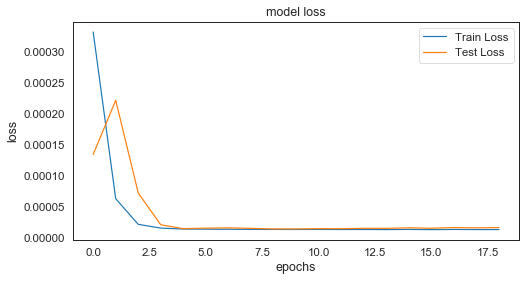

In [85]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

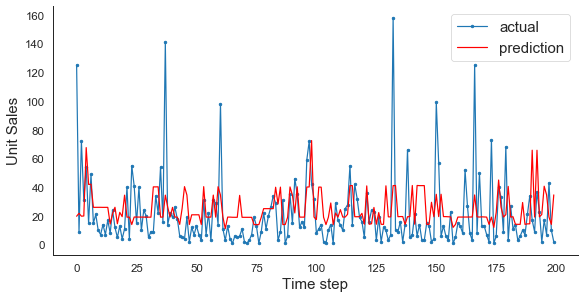

In [86]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Unit Sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### 1 cat - GROCERY I

In [189]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=1000, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 552812 samples, validate on 236920 samples
Epoch 1/100
552812/552812 [==============================] - 10s 19us/step - loss: 3.7509e-05 - val_loss: 6.9939e-06
Epoch 2/100
552812/552812 [==============================] - 9s 15us/step - loss: 8.1068e-06 - val_loss: 6.3405e-06
Epoch 3/100
552812/552812 [==============================] - 8s 15us/step - loss: 7.9282e-06 - val_loss: 7.0427e-06
Epoch 4/100
552812/552812 [==============================] - 13s 23us/step - loss: 7.9633e-06 - val_loss: 7.1010e-06
Epoch 5/100
552812/552812 [==============================] - 12s 21us/step - loss: 8.0234e-06 - val_loss: 7.3756e-06
Epoch 6/100
552812/552812 [==============================] - 10s 18us/step - loss: 8.0181e-06 - val_loss: 7.4790e-06
Epoch 7/100
552812/552812 [==============================] - 11s 20us/step - loss: 7.9886e-06 - val_loss: 6.8140e-06
Epoch 8/100
552812/552812 [==============================] - 12s 22us/step - loss: 7.9855e-06 - val_loss: 7.2198e-06
Epoch 9/100
55

Train Mean Absolute Error: 13.569975327356248
Train Root Mean Squared Error: 24.838693854803292
Test Mean Absolute Error: 15.560704746567154
Test Root Mean Squared Error: 23.067403172908964


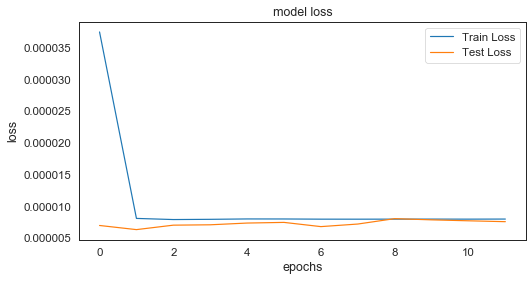

In [190]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler_y.inverse_transform(train_predict)
Y_train = scaler_y.inverse_transform([Y_train])
test_predict = scaler_y.inverse_transform(test_predict)
Y_test = scaler_y.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

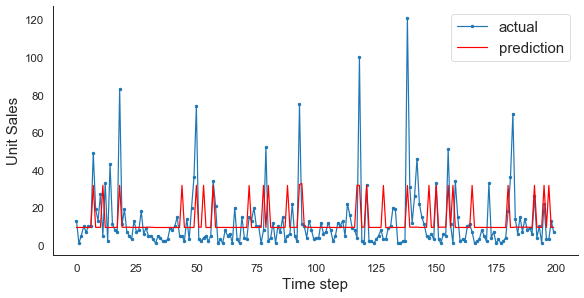

In [191]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Unit Sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [207]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(.2))

model.add(Dense(50))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.1))

model.add(Dense(25))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.05))

model.add(Dense(5))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.05))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=1000, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)


Train on 1655423 samples, validate on 709468 samples
Epoch 1/100
1655423/1655423 [==============================] - 51s 31us/step - loss: 0.0522 - val_loss: 0.0013
Epoch 2/100
1655423/1655423 [==============================] - 48s 29us/step - loss: 0.0026 - val_loss: 1.4644e-04
Epoch 3/100
1655423/1655423 [==============================] - 47s 28us/step - loss: 2.1214e-04 - val_loss: 2.2947e-05
Epoch 4/100
1655423/1655423 [==============================] - 47s 28us/step - loss: 2.1827e-05 - val_loss: 1.5224e-05
Epoch 5/100
1655423/1655423 [==============================] - 46s 28us/step - loss: 1.5297e-05 - val_loss: 1.6382e-05
Epoch 6/100
1655423/1655423 [==============================] - 45s 27us/step - loss: 1.5359e-05 - val_loss: 1.6723e-05
Epoch 7/100
1655423/1655423 [==============================] - 43s 26us/step - loss: 1.5410e-05 - val_loss: 1.6723e-05
Epoch 8/100
1655423/1655423 [==============================] - 43s 26us/step - loss: 1.5287e-05 - val_loss: 1.5908e-05
Epoch 9

Train Mean Absolute Error: 22.55835216008272
Train Root Mean Squared Error: 38.722411853842054
Test Mean Absolute Error: 22.968403194492375
Test Root Mean Squared Error: 38.93334455042983


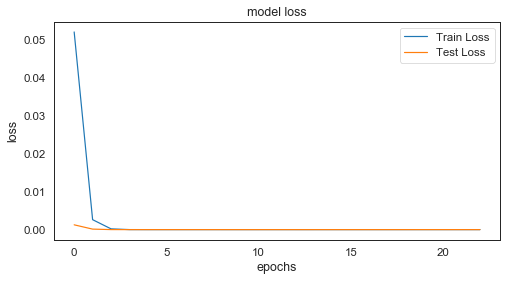

In [208]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler_y.inverse_transform(train_predict)
Y_train = scaler_y.inverse_transform([Y_train])
test_predict = scaler_y.inverse_transform(test_predict)
Y_test = scaler_y.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

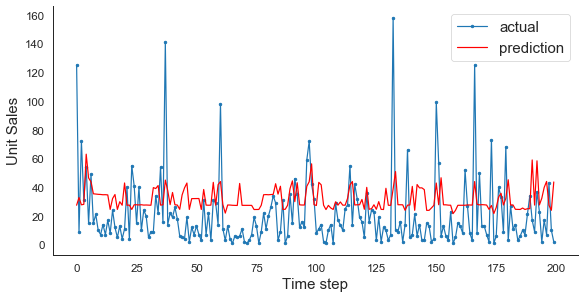

In [210]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Unit Sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# CNN 3 day look back

In [46]:
y = store_44['unit_sales'].values
df = store_44.drop(['index','id','date','store_nbr','class','unit_sales'],axis = 1)
df.values

array([[1.035200e+05, 0.000000e+00, 5.272000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.047735e+06, 0.000000e+00, 5.272000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.047734e+06, 0.000000e+00, 5.272000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [9.032840e+05, 1.000000e+00, 4.757000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.903740e+05, 0.000000e+00, 4.757000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [7.244030e+05, 1.000000e+00, 4.757000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [47]:
# univariate cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
# define input sequence
raw_seq = y
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle = False)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [55]:
print(X_test.shape,Y_train.shape)
X_test

(709467, 3, 1) (1655421,)


array([[[ 23.   ],
        [ 11.067],
        [125.   ]],

       [[ 11.067],
        [125.   ],
        [  9.   ]],

       [[125.   ],
        [  9.   ],
        [ 72.   ]],

       ...,

       [[ 15.   ],
        [  7.   ],
        [ 19.923]],

       [[  7.   ],
        [ 19.923],
        [ 14.087]],

       [[ 19.923],
        [ 14.087],
        [  1.   ]]])

In [120]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X_train, Y_train, epochs=100, batch_size=1000, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()


Train on 1655421 samples, validate on 709467 samples
Epoch 1/100
1655421/1655421 [==============================] - 8s 5us/step - loss: 1390.6216 - val_loss: 1385.3190
Epoch 2/100
1655421/1655421 [==============================] - 7s 4us/step - loss: 1371.5831 - val_loss: 1382.6401
Epoch 3/100
1655421/1655421 [==============================] - 7s 4us/step - loss: 1366.7241 - val_loss: 1379.8182
Epoch 4/100
1655421/1655421 [==============================] - 8s 5us/step - loss: 1363.2700 - val_loss: 1378.1137
Epoch 5/100
1655421/1655421 [==============================] - 8s 5us/step - loss: 1360.4862 - val_loss: 1376.0774
Epoch 6/100
1655421/1655421 [==============================] - 9s 5us/step - loss: 1358.4796 - val_loss: 1375.1050
Epoch 7/100
1655421/1655421 [==============================] - 8s 5us/step - loss: 1357.4273 - val_loss: 1376.6459
Epoch 8/100
1655421/1655421 [==============================] - 8s 5us/step - loss: 1356.3538 - val_loss: 1376.2509
Epoch 9/100
1655421/1655421

In [129]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict[:,0])))

Train Mean Absolute Error: 14.936982074560344
Train Root Mean Squared Error: 36.79706591918646
Test Mean Absolute Error: 15.228512779614967
Test Root Mean Squared Error: 37.078679638488815


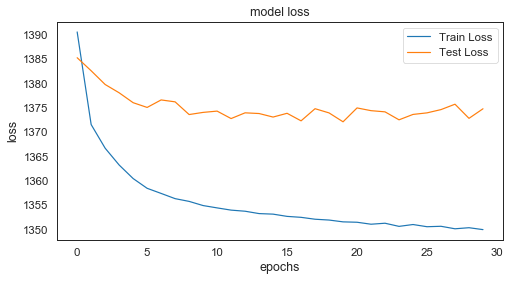

In [130]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

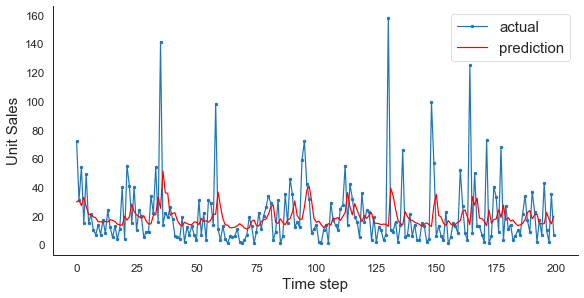

In [131]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Unit Sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# CNN multivariate GROCERY I

In [150]:
df = df[df['GROCERY I'] == 1]
y = store_44['unit_sales'].values
df = store_44.drop(['index','id','date','store_nbr','class','unit_sales'],axis = 1)

In [151]:
print(len(y),len(df['unit_sales1'].values))

2364891 2364891


In [152]:
# multivariate data preparation
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1= df['unit_sales1'].values
in_seq2= df['dcoilwtico'].values
out_seq= y
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
# summarize the data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle = False)
print(X_train.shape,Y_train.shape)


(2364889, 3, 2) (2364889,)
(1655422, 3, 2) (1655422,)


In [206]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, 2)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
#model.add(LSTM(50,stateful = True,return_sequences=True))
#model.add(LSTM(10, stateful=True))
#model.add(Dense(24))
#model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X_train, Y_train, epochs=100, batch_size=500, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()


ValueError: Error when checking input: expected conv1d_24_input to have shape (3, 2) but got array with shape (1, 46)

In [167]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict[:,0])))

Train Mean Absolute Error: 14.77966471417506
Train Root Mean Squared Error: 36.831447059526496
Test Mean Absolute Error: 15.324867570061897
Test Root Mean Squared Error: 37.07790295881275


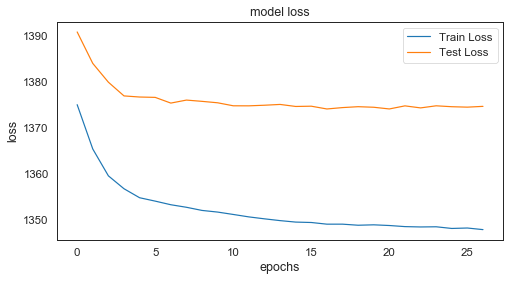

In [168]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

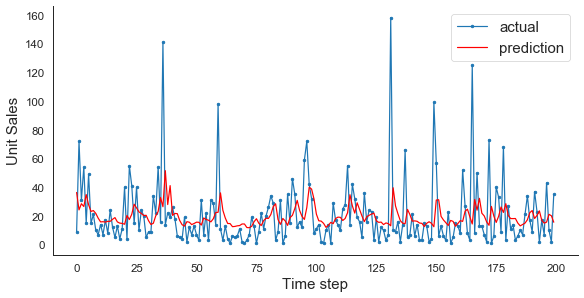

In [169]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Unit Sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## CNN + LSTM?

In [170]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, 2))))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(LSTM(50,stateful = True,return_sequences=True))
model.add(LSTM(10, stateful=True))
model.add(Dense(24))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, Y_train, epochs=100, batch_size=1000, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

ValueError: Input tensor must be of rank 3, 4 or 5 but was 2.

## One store 2015-2017 LSTM 7 days lag all cat

In [56]:
dataset = category_1_store_44.unit_sales.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 7
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,Y_train.shape)

(288580, 7)
(288580, 1, 7) (288580,)


In [57]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=50, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 288580 samples, validate on 123673 samples
Epoch 1/100
288580/288580 [==============================] - 23s 79us/step - loss: 3.1088e-05 - val_loss: 3.6016e-05
Epoch 2/100
288580/288580 [==============================] - 23s 79us/step - loss: 3.0508e-05 - val_loss: 3.6065e-05
Epoch 3/100
288580/288580 [==============================] - 24s 82us/step - loss: 3.0467e-05 - val_loss: 3.6073e-05
Epoch 4/100
288580/288580 [==============================] - 25s 87us/step - loss: 3.0403e-05 - val_loss: 3.6056e-05
Epoch 5/100
288580/288580 [==============================] - 26s 90us/step - loss: 3.0428e-05 - val_loss: 3.6068e-05
Epoch 6/100
288580/288580 [==============================] - 29s 100us/step - loss: 3.0361e-05 - val_loss: 3.6033e-05
Epoch 7/100
288580/288580 [==============================] - 27s 95us/step - loss: 3.0352e-05 - val_loss: 3.6042e-05
Epoch 8/100
288580/288580 [==============================] - 28s 97us/step - loss: 3.0391e-05 - val_loss: 3.6026e-05
Epoch 9/100

Epoch 70/100
288580/288580 [==============================] - 22s 78us/step - loss: 3.0199e-05 - val_loss: 3.5862e-05
Epoch 71/100
288580/288580 [==============================] - 23s 81us/step - loss: 3.0232e-05 - val_loss: 3.5829e-05
Epoch 72/100
288580/288580 [==============================] - 23s 78us/step - loss: 3.0209e-05 - val_loss: 3.5856e-05
Epoch 73/100
288580/288580 [==============================] - 23s 78us/step - loss: 3.0203e-05 - val_loss: 3.5825e-05
Epoch 74/100
288580/288580 [==============================] - 25s 87us/step - loss: 3.0220e-05 - val_loss: 3.5818e-05
Epoch 75/100
288580/288580 [==============================] - 22s 75us/step - loss: 3.0217e-05 - val_loss: 3.5840e-05
Epoch 76/100
288580/288580 [==============================] - 23s 80us/step - loss: 3.0271e-05 - val_loss: 3.5848e-05
Epoch 77/100
288580/288580 [==============================] - 23s 80us/step - loss: 3.0273e-05 - val_loss: 3.5835e-05
Epoch 78/100
288580/288580 [============================

KeyboardInterrupt: 

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('unit sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## One cat 7Days lag 

In [58]:
category_1_store_44_frozen = category_1_store_44[category_1_store_44['family'] == "FROZEN FOODS"]
dataset = category_1_store_44_frozen.unit_sales.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 7
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,Y_train.shape)

(22576, 7)
(22576, 1, 7) (22576,)


In [59]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=50, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 22576 samples, validate on 9672 samples
Epoch 1/100
22576/22576 [==============================] - 3s 124us/step - loss: 2.3592e-04 - val_loss: 2.6516e-04
Epoch 2/100
22576/22576 [==============================] - 2s 81us/step - loss: 2.3602e-04 - val_loss: 2.4957e-04
Epoch 3/100
22576/22576 [==============================] - 2s 72us/step - loss: 2.2765e-04 - val_loss: 2.4961e-04
Epoch 4/100
22576/22576 [==============================] - 2s 74us/step - loss: 2.2632e-04 - val_loss: 2.4761e-04
Epoch 5/100
22576/22576 [==============================] - 2s 74us/step - loss: 2.2519e-04 - val_loss: 2.4822e-04
Epoch 6/100
22576/22576 [==============================] - 2s 76us/step - loss: 2.2565e-04 - val_loss: 2.4855e-04
Epoch 7/100
22576/22576 [==============================] - 2s 76us/step - loss: 2.2435e-04 - val_loss: 2.4613e-04
Epoch 8/100
22576/22576 [==============================] - 2s 80us/step - loss: 2.2234e-04 - val_loss: 2.4705e-04
Epoch 9/100
22576/22576 [=============

In [60]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 13.258083518917342
Train Root Mean Squared Error: 53.704444140819966
Test Mean Absolute Error: 16.012918569383867
Test Root Mean Squared Error: 57.62025257860238


In [68]:
category_1_store_44_frozen.groupby('item_nbr').count()

,index,id,date,store_nbr,unit_sales,family,class,perishable,dcoilwtico,day_of_year,day_of_week,week_of_year,onpromotion_cat,year
item_nbr,,,,,,,,,,,,,,
208530,232,232,232,232,232,232,232,232,232,232,232,232,232,232
258411,922,922,922,922,922,922,922,922,922,922,922,922,922,922
264576,943,943,943,943,943,943,943,943,943,943,943,943,943,943
457574,351,351,351,351,351,351,351,351,351,351,351,351,351,351
507457,941,941,941,941,941,941,941,941,941,941,941,941,941,941
557241,251,251,251,251,251,251,251,251,251,251,251,251,251,251
700609,893,893,893,893,893,893,893,893,893,893,893,893,893,893
700610,872,872,872,872,872,872,872,872,872,872,872,872,872,872
743496,944,944,944,944,944,944,944,944,944,944,944,944,944,944


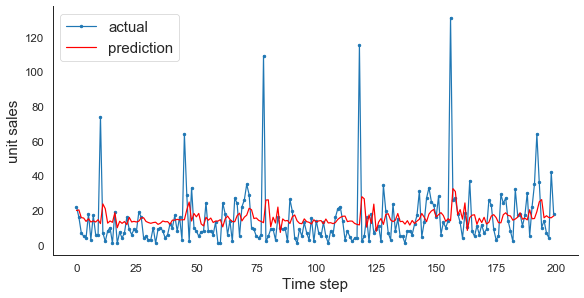

In [61]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('unit sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# One Item

In [ ]:
df_chunk = pd.read_csv('train.csv',chunksize=1000000,parse_dates = ['date'])

chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in df_chunk:  
    chunk_list.append(chunk)
    
# concat the list into dataframe 
dataset = pd.concat(chunk_list)

In [ ]:
#taking only store 44 and item number 1503844
trimmed_df = dataset[(dataset['store_nbr'] == 44) & (dataset['item_nbr'] == 1503844)].reset_index()
#trimmed_df = trimmed_df.drop(['index'],axis=1)
trimmed_df.to_excel('trimmed_df.xlsx',index = False)

In [ ]:
df = preprocess_data(trimmed_df)
df.to_excel('df.xlsx',index = False)
df.columns.values
df = df.drop(['index','id','store_nbr','item_nbr'],axis = 1)
df.to_excel('df_for_time_seris.xlsx',index = False)
y = df['unit_sales']
df = df.drop(['unit_sales'],axis = 1)
df['y'] = y

In [ ]:
df = pd.read_excel("df.xlsx")
df.columns.values
df = df.drop(['index','id','store_nbr','item_nbr'],axis = 1)
df.to_excel('df_for_time_seris.xlsx',index = False)
y = df['unit_sales']
df = df.drop(['unit_sales'],axis = 1)
df['y'] = y

In [ ]:
df

### There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K² Test.

In [ ]:
stat, p = stats.normaltest(df.y)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

### determine if the data distribution departs from the normal distribution.

In [ ]:
sns.distplot(df.y);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.y)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.y)))

#### Kurtosis: describes heaviness of the tails of a distribution
Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero.

#### Skewness: measures asymmetry of the distribution
If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

In [ ]:
df1=df.loc[:,['date','y']]
df1.set_index('date',inplace=True)
df1.plot(figsize=(12,5))

plt.ylabel('Unit Sales')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Sales over time')
sns.despine(top=True)
plt.show();

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="y", data=df)
plt.xlabel('year')
plt.title('Box plot of y')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="y", data=df)
plt.xlabel('quarter')
plt.title('Box plot of y')
sns.despine(left=True)
plt.tight_layout();

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['y'].hist(bins=50)
plt.title('Unit Sales Distribution')
plt.subplot(1,2,2)
stats.probplot(df['y'], plot=plt);
df1.describe().T

In [ ]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['y'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Unit Sales resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['y'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Unit Sales resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['y'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Unit Sales resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['y'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Unit Sales resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['y'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Unit Sales resampled over year')
ax5.tick_params(axis='both', which='major');

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').y.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
df.groupby('quarter').y.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
df.groupby('month').y.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
df.groupby('day_of_week').y.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

In [ ]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "y", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

In [ ]:
pd.pivot_table(dataset.loc[dataset['year'] != 2006], values = "y", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

In [ ]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','y',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

In [ ]:
plt1=sns.factorplot('year','y',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of unit sales power by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

### Dickey-Fuller test
#### Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
#### Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.y.dropna())

From the above results, we will reject the null hypothesis H0, the data does not have a unit root and is stationary.

## LSTM

In [ ]:
df_temp = df.drop(['unit_sales1','unit_sales2','unit_sales3','unit_sales4','unit_sales5','unit_sales6','unit_sales6','unit_sales7'],axis = 1)
df_temp

### 7 Day look back unit sales only

In [ ]:
dataset = df_temp.y.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 7
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,Y_train.shape)

In [ ]:
dataset = df_temp.y.values #numpy.ndarray
dataset = np.asarray(dataset.astype('float32'))
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 7
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,Y_train.shape)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, Y_train, epochs=200, batch_size=10, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=10, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('unit sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### Differencing

In [ ]:
dataset = df_temp.y.values #numpy.ndarray

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob
diff = difference(dataset)
inverted = [inverse_difference(dataset[i], diff[i]) for i in range(len(diff))]

len(dataset[:train_size]

In [ ]:
dataset = df_temp.y.values #numpy.ndarray
dataset = dataset.astype('float32')

dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 7
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,Y_train.shape)

In [ ]:
X_train = X_train[:-1]
X_test = X_test[:-1]
Y_train = np.asarray(difference(Y_train))
Y_test = np.asarray(difference(Y_test))
len(Y_train)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=20, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
train_predict

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
train_org = dataset[:train_size]
len(train_org)

In [ ]:
[inverse_difference(train_org[i], Y_train[0][i]) for i in range(len(diff))]

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### lookback 7 + day features + oil feature

In [ ]:
df_temp_2 = df_temp.drop(['date', 'Day'],axis =1)
df_temp_2

In [ ]:
df_temp_3 = df.drop(['date', 'Day','y'],axis =1)
dataset = df_temp_3.values
y = df['y'].values
y = np.reshape(y, (-1, 1))

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)
#y = scaler.fit_transform(y)
X_train, X_test, Y_train, Y_test = train_test_split(dataset, y, test_size=0.3, random_state=1, shuffle = False)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
Y_train = np.asarray(Y_train)
Y_test = np.asarray(Y_test)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Y_train_2 = []
for y in Y_train:
    Y_train_2.append(y[0])
Y_train = np.asarray(Y_train_2)

Y_test_2 = []
for y in Y_test:
    Y_test_2.append(y[0])
Y_test = np.asarray(Y_test_2)
print(X_train.shape,Y_train.shape)

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=10, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Unit Sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## cnn

In [ ]:
# define input sequence
dataset = df_temp.y.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.asarray(dataset)
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

In [ ]:
train

In [ ]:

# univariate cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = train

# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X

In [ ]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = np.asarray(test)
x_input = x_input.reshape((x_input.shape[0], x_input.shape[1], n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

## Feedforward

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
#base NN

In [ ]:
df_x = df.drop(['y'],axis = 1)
df_y = y
y = df_y.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(df_x.values, y, test_size=0.3, random_state=1, shuffle = False)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [ ]:
print(X_train.shape,X_test.shape)

In [ ]:
print(y_train.shape,y_test.shape)

In [ ]:
#build our model
def basic_model():
    model = Sequential()

    model.add(Dense(50, activation='relu',input_dim = 15))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(925,15)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
              
model_1 = basic_model()

In [ ]:
model_1.fit(
    X_train,
    y_train,
    epochs=200,
    shuffle=False,
    verbose=2,
    batch_size =80
)

In [ ]:
prediction_train = model_1.predict(X_train)
prediction = model_1.predict(X_test)

In [ ]:
print("RMSE:",math.sqrt(mean_squared_error(y_train,prediction_train)),"R2:",r2_score(prediction_train,y_train))

In [ ]:
print("RMSE:",math.sqrt(mean_squared_error(y_test,prediction)),"R2:",r2_score(prediction,y_test))

In [ ]:
plt.scatter(prediction_train,y_train)


In [ ]:
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/